In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

# import from custom package
from auxFuns.EDA import *

# 1. Exploration of ML algorithms and visualization of their decision boundaries
- Fitting various ML algorithms (linear, tree-based, distance-based)
- Interpretability and explanation

In [6]:
# Load data sets under study (VSCode)
# raw_datasets_path = os.getcwd() + '/datasets/raw'
# processed_datasets_path = os.getcwd() + '/datasets/processed'

# rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)

# Load data sets under study (GColab)
rsv_predictors_phase1_df = pd.read_csv('/content/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_daysDedup_df = pd.read_csv('/content/rsv_predictors_phase1_daysDedup.csv', low_memory=False)

In [28]:
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

rsv_predictors_phase1_df.shape, rsv_predictors_phase1_daysDedup_df.shape

# Extract a reduced sample of the data for modelling
# sample_size = 80000
# sample_rsv_df = rsv_predictors_phase1_df.sample(n = sample_size)
# sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.sample(n = sample_size)

sample_rsv_df = rsv_predictors_phase1_df.copy()
sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.copy()

In [29]:
sample_rsv_df['RSV_test_result'].value_counts(), sample_dedup_rsv_df['RSV_test_result'].value_counts()

(Negative    84005
 Positive     2654
 Name: RSV_test_result, dtype: int64,
 Negative    83404
 Positive     2654
 Name: RSV_test_result, dtype: int64)

In [44]:
# Fit and evaluate an initial simple model for each sample data
# random forest
# optimize for f1-score (recall, precision average)
# produce confusion matrix for both

df1 = sample_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters','n_tests_that_day'], axis = 1)
df2 = sample_dedup_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters','n_tests_that_day','Unnamed: 0','test_combination'], axis = 1)

# Separate the target variable and predictor variables for df1
X1 = df1.drop(['RSV_test_result'], axis=1)
X1 = pd.get_dummies(X1, drop_first = True)
y1 = df1['RSV_test_result']

# Separate the target variable and predictor variables for df2
X2 = df2.drop(['RSV_test_result'], axis=1)
X2 = pd.get_dummies(X2, drop_first = True)

y2 = df2['RSV_test_result']

# Split the data into train and test sets for df1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Split the data into train and test sets for df2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialize the classifier
rfc = RandomForestClassifier()

# Create the parameter grid
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}

# Create the scorer
f1_scorer = make_scorer(f1_score, average='macro')


Best parameters for df1:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 7}
Best f1 score for df1:  0.6029317956473127


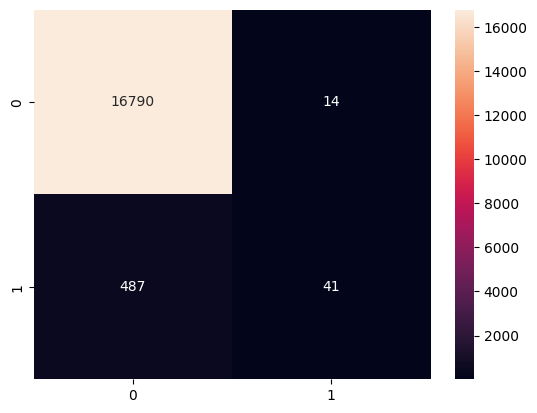

In [45]:
# Create the GridSearchCV object for df1
grid_search1 = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=f1_scorer, cv=5)

# Fit the GridSearchCV object to the data
grid_search1.fit(X1_train, y1_train)

# Predict the labels of the test set: y1_pred
y1_pred = grid_search1.predict(X1_test)

# Print the best parameters and the best f1 score
print('Best parameters for df1: ', grid_search1.best_params_)
print('Best f1 score for df1: ', grid_search1.best_score_)

# Compute and print the confusion matrix and classification report
matrix1 = confusion_matrix(y1_test, y1_pred)
sns.heatmap(matrix1, annot=True, fmt='d')
plt.show()


Best parameters for df2:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 14}
Best f1 score for df2:  0.6226651056244744


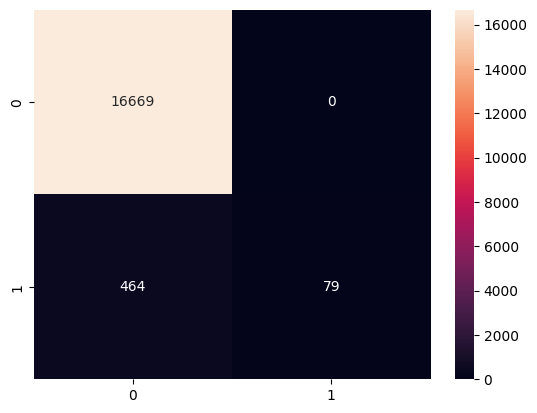

In [46]:

# Repeat the process for df2
grid_search2 = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=f1_scorer, cv=5)
grid_search2.fit(X2_train, y2_train)
y2_pred = grid_search2.predict(X2_test)
print('Best parameters for df2: ', grid_search2.best_params_)
print('Best f1 score for df2: ', grid_search2.best_score_)
matrix2 = confusion_matrix(y2_test, y2_pred)
sns.heatmap(matrix2, annot=True, fmt='d')
plt.show()

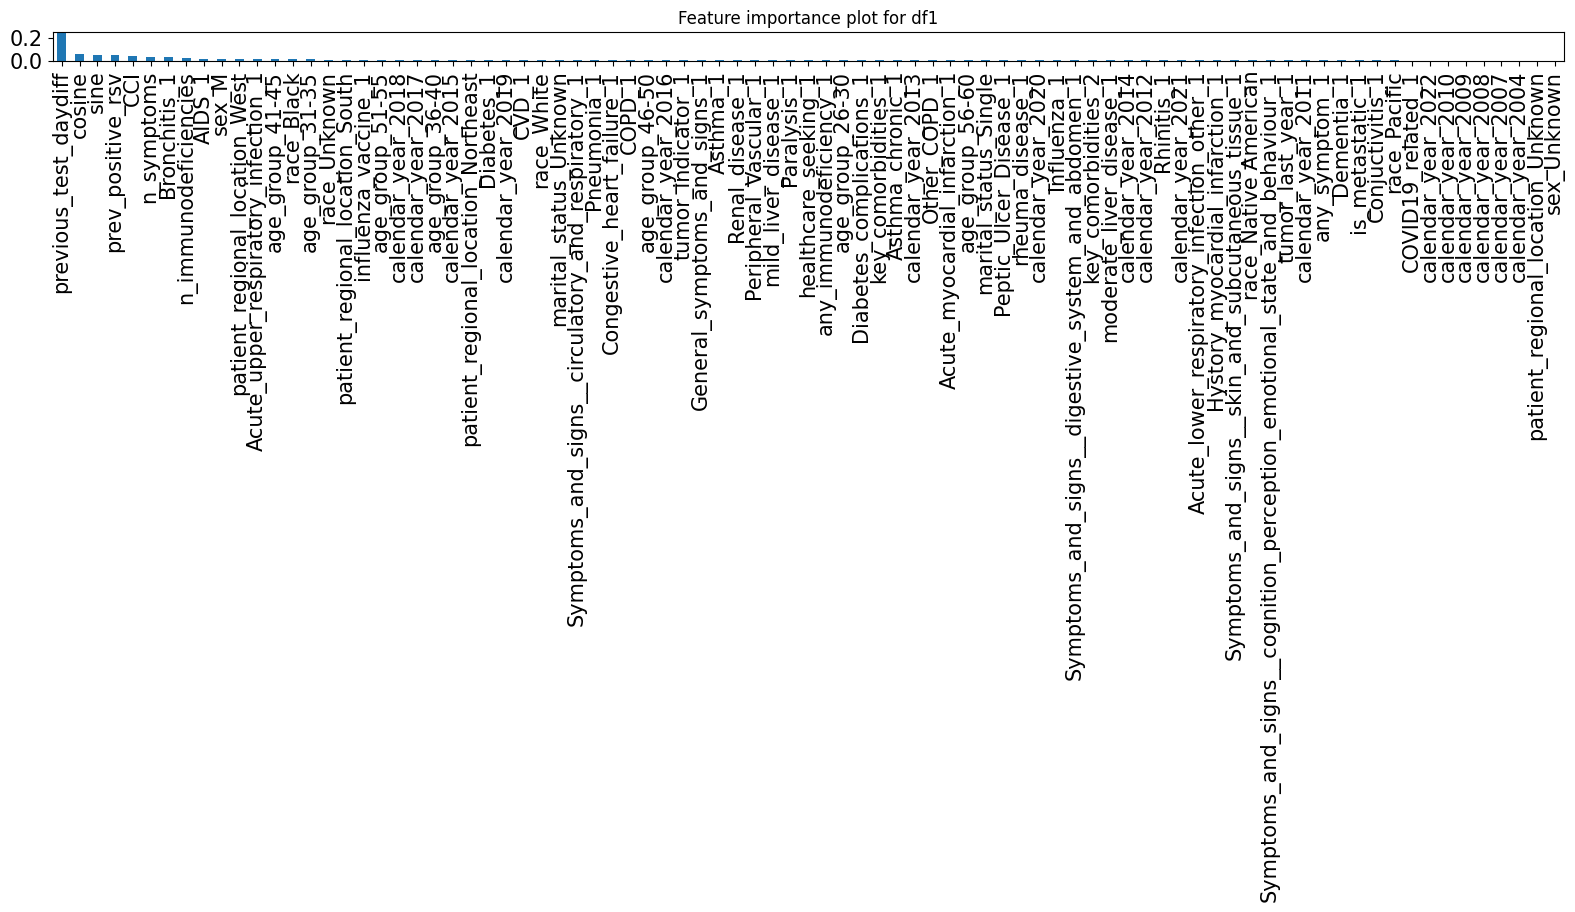

In [47]:
# Include a feature importance diagram for interpretability

best_rf1 = grid_search1.best_estimator_

# Get feature importances
importances1 = best_rf1.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances1 = pd.Series(importances1, X1.columns)

# Sort the array in descending order of the importances
f_importances1.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances
f_importances1.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90, fontsize=15)

# Show the plot
plt.tight_layout()
plt.title("Feature importance plot for df1")
plt.show()

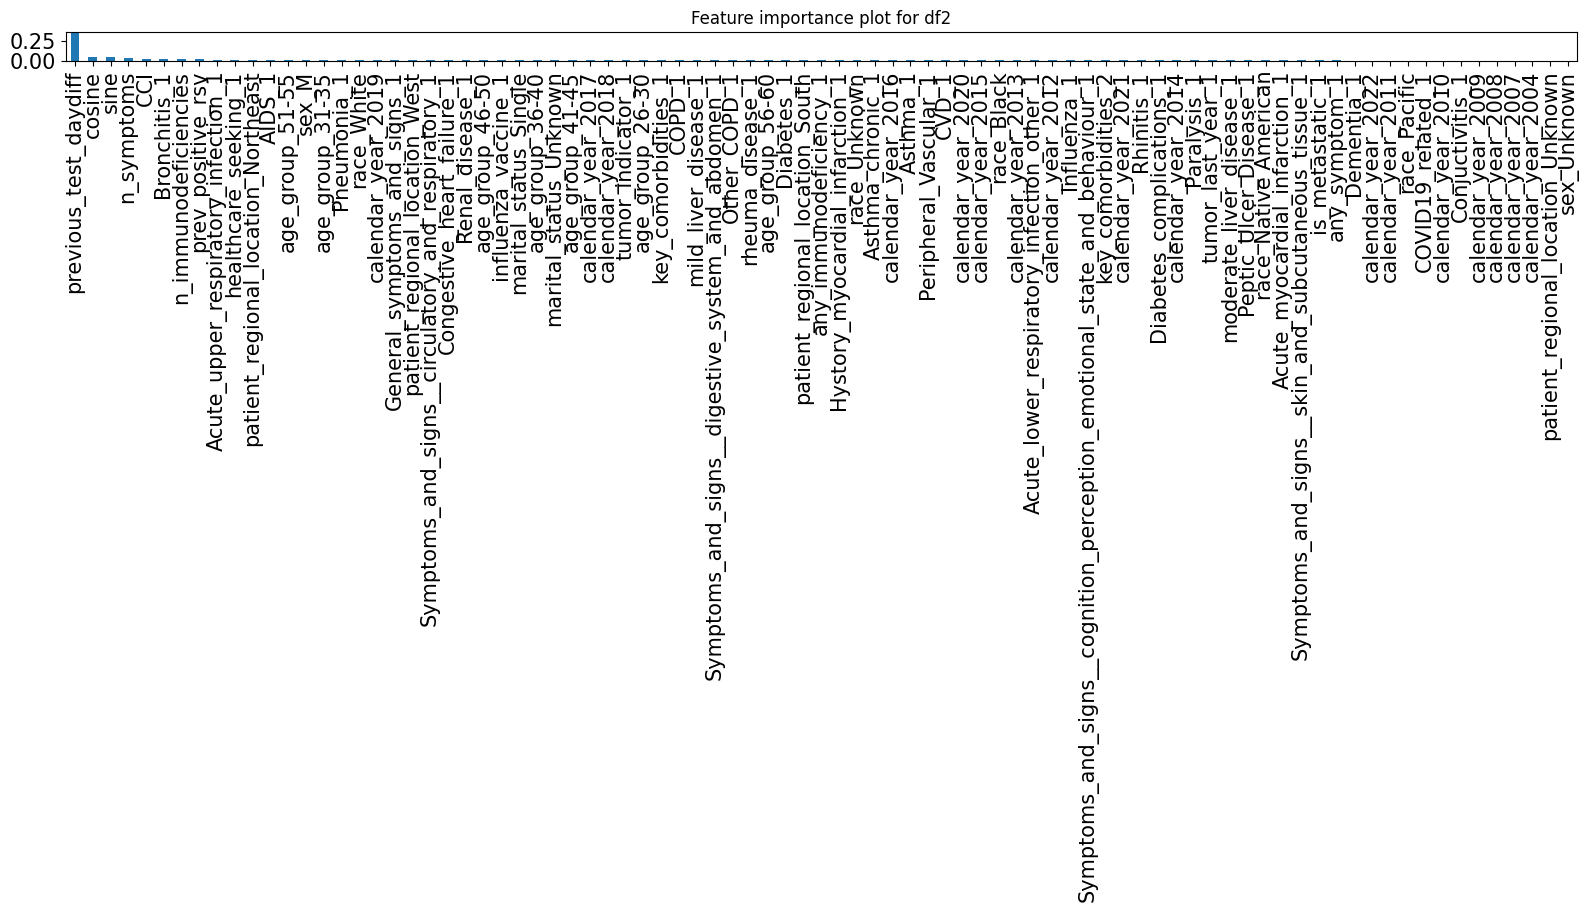

In [48]:
best_rf2 = grid_search2.best_estimator_

# Get feature importances
importances2 = best_rf2.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances2 = pd.Series(importances2, X2.columns)

# Sort the array in descending order of the importances
f_importances2.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances
f_importances2.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90, fontsize=15)

# Show the plot
plt.tight_layout()
plt.title("Feature importance plot for df2")
plt.show()